<a href="https://colab.research.google.com/github/eleanarey/ProgramingPractices/blob/main/implementacion_de_vit_jax_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

See code at https://github.com/google-research/vision_transformer/

See papers at

- Vision Transformer: https://arxiv.org/abs/2010.11929
- MLP-Mixer: https://arxiv.org/abs/2105.01601
- How to train your ViT: https://arxiv.org/abs/2106.10270
- When Vision Transformers Outperform ResNets without Pretraining or Strong Data Augmentations: https://arxiv.org/abs/2106.01548

This Colab allows you to run the [JAX](https://jax.readthedocs.org) implementation of the Vision Transformer.

If you just want to load a pre-trained checkpoint from a large repository and
directly use it for inference, you probably want to go [this Colab](https://colab.research.google.com/github/google-research/vision_transformer/blob/main/vit_jax_augreg.ipynb).

##### Copyright 2021 Google LLC.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

<a href="https://colab.research.google.com/github/google-research/vision_transformer/blob/main/vit_jax.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Setup

Needs to be executed once in every VM.

The cell below downloads the code from Github and install necessary dependencies.

In [2]:
#@markdown Select whether you would like to store data in your personal drive.
#@markdown
#@markdown If you select **yes**, you will need to authorize Colab to access
#@markdown your personal drive
#@markdown
#@markdown If you select **no**, then any changes you make will diappear when
#@markdown this Colab's VM restarts after some time of inactivity...
use_gdrive = 'yes'  #@param ["yes", "no"]


if use_gdrive == 'yes':
  from google.colab import drive
  # Montar Google Drive
  # "comentamos esta celda y añadimos la siguiente" drive.mount('/gdrive')
  drive.mount('/content/drive', force_remount=True)
  # Ruta al archivo ZIP en Google Drive
  # "comentamos esta celda y añadimos la siguiente" root = '/gdrive/My Drive/vision_transformer_colab'
  root = "/content/drive/MyDrive/Colab_Notebooks"
  import os
  if not os.path.isdir(root):
    os.mkdir(root)
  os.chdir(root)
  print(f'\nChanged CWD to "{root}"')
else:
  from IPython import display
  display.display(display.HTML(
      '<h1 style="color:red">CHANGES NOT PERSISTED</h1>'))

Mounted at /content/drive

Changed CWD to "/content/drive/MyDrive/Colab_Notebooks"


In [3]:
# Clone repository and pull latest changes.
![ -d vision_transformer ] || git clone --depth=1 https://github.com/google-research/vision_transformer
!cd vision_transformer && git pull

Cloning into 'vision_transformer'...
remote: Enumerating objects: 49, done.
remote: Counting objects: 100% (49/49), done.
remote: Compressing objects: 100% (40/40), done.
remote: Total 49 (delta 6), reused 30 (delta 5), pack-reused 0 (from 0)
Receiving objects: 100% (49/49), 2.02 MiB | 8.57 MiB/s, done.
Resolving deltas: 100% (6/6), done.
Already up to date.


In [4]:
# Colab already includes most of the dependencies, so we only install the delta:
!pip install einops>=0.3.0 ml-collections>=0.1.0 aqtp>=0.2.0 clu>=0.0.3 git+https://github.com/google/flaxformer tensorflow-text>=2.9.0

#añadido
!pip install opencv-python-headless


#!pip install -qr vision_transformer/vit_jax/requirements.txt

  Running command git clone --filter=blob:none --quiet https://github.com/google/flaxformer /tmp/pip-req-build-csgqexch


### Imports

Los datos que consltan en esta sección provienen de un bucket de Google Cloud Storage. En este caso, las líneas de código con el comando gsutil están accediendo a recursos almacenados en los buckets [gs://vit_models/](https://) y [gs://mixer_models/](https://).

### ¿Qué son estos buckets?
Un bucket es un contenedor en Google Cloud Storage donde se almacenan archivos o datos de manera organizada.

En este caso:

[gs://vit_models/](https://): Almacena modelos preentrenados de Vision Transformer (ViT).
Por ejemplo:
Modelos entrenados en ImageNet (imagenet*).
Modelos SAM (Segment Anything Models).

[gs://mixer_models/](https://): Almacena modelos relacionados con MLP-Mixer, otra arquitectura para visión por computadora.

## Explicación de los comandos:

### !gsutil ls -lh gs://vit_models/imagenet*:
Lista todos los modelos preentrenados de ViT que se entrenaron usando el dataset ImageNet.
Muestra información como tamaño del archivo y la ruta.

### !gsutil ls -lh gs://vit_models/sam:
Lista modelos de SAM disponibles en ese bucket.

### !gsutil ls -lh gs://mixer_models/*:
Lista los modelos de MLP-Mixer disponibles.

In [5]:
# Shows all available pre-trained models.
!gsutil ls -lh gs://vit_models/imagenet*
!gsutil ls -lh gs://vit_models/sam
!gsutil ls -lh gs://mixer_models/*

gs://vit_models/imagenet21k+imagenet2012/:
377.57 MiB  2020-11-30T16:17:02Z  gs://vit_models/imagenet21k+imagenet2012/R50+ViT-B_16.npz
330.29 MiB  2020-10-29T17:05:52Z  gs://vit_models/imagenet21k+imagenet2012/ViT-B_16-224.npz
 331.4 MiB  2020-10-20T11:48:22Z  gs://vit_models/imagenet21k+imagenet2012/ViT-B_16.npz
336.89 MiB  2020-10-20T11:47:36Z  gs://vit_models/imagenet21k+imagenet2012/ViT-B_32.npz
334.78 MiB  2021-03-12T09:04:16Z  gs://vit_models/imagenet21k+imagenet2012/ViT-B_8.npz
  1.13 GiB  2020-10-29T17:08:31Z  gs://vit_models/imagenet21k+imagenet2012/ViT-L_16-224.npz
  1.14 GiB  2020-10-20T11:53:44Z  gs://vit_models/imagenet21k+imagenet2012/ViT-L_16.npz
  1.14 GiB  2020-10-20T11:50:56Z  gs://vit_models/imagenet21k+imagenet2012/ViT-L_32.npz

gs://vit_models/imagenet21k/:
450.23 MiB  2021-01-20T14:12:43Z  gs://vit_models/imagenet21k/R26+ViT-B_32.npz
439.85 MiB  2020-11-30T10:10:15Z  gs://vit_models/imagenet21k/R50+ViT-B_16.npz
  1.31 GiB  2021-01-20T14:11:54Z  gs://vit_models/ima

In [6]:
# Download a pre-trained model.

# Note: you can really choose any of the above, but this Colab has been tested
# with the models of below selection...
model_name = 'ViT-B_32'  #@param ["ViT-B_32", "Mixer-B_16"]

if model_name.startswith('ViT'):
  ![ -e "$model_name".npz ] || gsutil cp gs://vit_models/imagenet21k/"$model_name".npz .
if model_name.startswith('Mixer'):
  ![ -e "$model_name".npz ] || gsutil cp gs://mixer_models/imagenet21k/"$model_name".npz .

import os
assert os.path.exists(f'{model_name}.npz')

Copying gs://vit_models/imagenet21k/ViT-B_32.npz...
==> NOTE: You are downloading one or more large file(s), which would
run significantly faster if you enabled sliced object downloads. This
feature is enabled by default but requires that compiled crcmod be
installed (see "gsutil help crcmod").

| [1 files][400.0 MiB/400.0 MiB]   37.0 MiB/s                                   
Operation completed over 1 objects/400.0 MiB.                                    


In [7]:
# Google Colab "TPU" runtimes are configured in "2VM mode", meaning that JAX
# cannot see the TPUs because they're not directly attached. Instead we need to
# setup JAX to communicate with a second machine that has the TPUs attached.
import os
if 'google.colab' in str(get_ipython()) and 'COLAB_TPU_ADDR' in os.environ:
  import jax
  import jax.tools.colab_tpu
  jax.tools.colab_tpu.setup_tpu()
  print('Connected to TPU.')
else:
  print('No TPU detected. Can be changed under "Runtime/Change runtime type".')
#Se incluyen estas lineas para explicar y corregir el error
#¿Por qué aparece "No TPU detected"?
#Esto ocurre porque el entorno de ejecución actual no tiene configurado el uso de un TPU. Probablemente estás ejecutando el Colab en un entorno estándar (CPU o GPU).
#Para activar un TPU en Google Colab se debe cambiar el tipo de entorno de ejecución:
#En el menú superior de Colab:
#Ve a "Runtime" > "Change runtime type".
#En "Hardware accelerator", selecciona TPU. Haz clic en "Save" y reinicia el entorno
#Después de cambiar a TPU, Colab asignará un TPU y configurará la variable de entorno COLAB_TPU_ADDR.

No TPU detected. Can be changed under "Runtime/Change runtime type".


In [8]:
!echo $COLAB_TPU_ADDR

In [9]:
import os
print(os.environ.get('COLAB_TPU_ADDR'))


None


In [10]:
import tensorflow as tf
print("GPU disponible:", tf.config.list_physical_devices('GPU'))

GPU disponible: []


In [11]:
from absl import logging
import flax
import jax
from matplotlib import pyplot as plt
import numpy as np
import optax
import tqdm

logging.set_verbosity(logging.INFO)

# Shows the number of available devices.
# In a CPU/GPU runtime this will be a single device.
# In a TPU runtime this will be 8 cores.
jax.local_devices()

[TpuDevice(id=0, process_index=0, coords=(0,0,0), core_on_chip=0),
 TpuDevice(id=1, process_index=0, coords=(0,0,0), core_on_chip=1),
 TpuDevice(id=2, process_index=0, coords=(1,0,0), core_on_chip=0),
 TpuDevice(id=3, process_index=0, coords=(1,0,0), core_on_chip=1),
 TpuDevice(id=4, process_index=0, coords=(0,1,0), core_on_chip=0),
 TpuDevice(id=5, process_index=0, coords=(0,1,0), core_on_chip=1),
 TpuDevice(id=6, process_index=0, coords=(1,1,0), core_on_chip=0),
 TpuDevice(id=7, process_index=0, coords=(1,1,0), core_on_chip=1)]

In [12]:
# Open some code files in a split editor on the right.
# You can open more files in the file tab on the left.

# Si ejecutas este código en un Colab, verás los archivos abiertos en la parte derecha. Desde allí puedes:
# Leer el contenido de los archivos para entender cómo está estructurado el proyecto.
# Realizar ediciones rápidas en el código.
# Guardar los cambios en tu sesión de Colab o descargar los archivos modificados.

from google.colab import files
files.view('vision_transformer/vit_jax/configs/common.py')
files.view('vision_transformer/vit_jax/configs/models.py')
files.view('vision_transformer/vit_jax/checkpoint.py')
files.view('vision_transformer/vit_jax/input_pipeline.py')
files.view('vision_transformer/vit_jax/models.py')
files.view('vision_transformer/vit_jax/train.py')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [13]:
# Import files from repository.
# Updating the files in the editor on the right will immediately update the
# modules by re-importing them.

import sys
if './vision_transformer' not in sys.path:
  sys.path.append('./vision_transformer')

%load_ext autoreload
%autoreload 2

from vit_jax import checkpoint
from vit_jax import input_pipeline
from vit_jax import utils
from vit_jax import models
from vit_jax import train
from vit_jax.configs import common as common_config
from vit_jax.configs import models as models_config

In [14]:
# Helper functions for images.

labelnames = dict(
  # https://www.cs.toronto.edu/~kriz/cifar.html
  cifar10=('airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'),
  # https://www.cs.toronto.edu/~kriz/cifar.html
  cifar100=('apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle', 'bicycle', 'bottle', 'bowl', 'boy', 'bridge', 'bus', 'butterfly', 'camel', 'can', 'castle', 'caterpillar', 'cattle', 'chair', 'chimpanzee', 'clock', 'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 'cup', 'dinosaur', 'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster', 'house', 'kangaroo', 'computer_keyboard', 'lamp', 'lawn_mower', 'leopard', 'lion', 'lizard', 'lobster', 'man', 'maple_tree', 'motorcycle', 'mountain', 'mouse', 'mushroom', 'oak_tree', 'orange', 'orchid', 'otter', 'palm_tree', 'pear', 'pickup_truck', 'pine_tree', 'plain', 'plate', 'poppy', 'porcupine', 'possum', 'rabbit', 'raccoon', 'ray', 'road', 'rocket', 'rose', 'sea', 'seal', 'shark', 'shrew', 'skunk', 'skyscraper', 'snail', 'snake', 'spider', 'squirrel', 'streetcar', 'sunflower', 'sweet_pepper', 'table', 'tank', 'telephone', 'television', 'tiger', 'tractor', 'train', 'trout', 'tulip', 'turtle', 'wardrobe', 'whale', 'willow_tree', 'wolf', 'woman', 'worm')
)
def make_label_getter(dataset):
  """Returns a function converting label indices to names."""
  def getter(label):
    if dataset in labelnames:
      return labelnames[dataset][label]
    return f'label={label}'
  return getter

def show_img(img, ax=None, title=None):
  """Shows a single image."""
  if ax is None:
    ax = plt.gca()
  ax.imshow(img[...])
  ax.set_xticks([])
  ax.set_yticks([])
  if title:
    ax.set_title(title)

def show_img_grid(imgs, titles):
  """Shows a grid of images."""
  n = int(np.ceil(len(imgs)**.5))
  _, axs = plt.subplots(n, n, figsize=(3 * n, 3 * n))
  for i, (img, title) in enumerate(zip(imgs, titles)):
    img = (img + 1) / 2  # Denormalize
    show_img(img, axs[i // n][i % n], title)

### Load dataset

In [15]:
dataset = 'cifar10'
batch_size = 512
config = common_config.with_dataset(common_config.get_config(), dataset)
config.batch = batch_size
config.pp.crop = 224

In [16]:
# For details about setting up datasets, see input_pipeline.py on the right.
ds_train = input_pipeline.get_data_from_tfds(config=config, mode='train')
ds_test = input_pipeline.get_data_from_tfds(config=config, mode='test')
num_classes = input_pipeline.get_dataset_info(dataset, 'train')['num_classes']
del config  # Only needed to instantiate datasets.

INFO:absl:Load dataset info from /root/tensorflow_datasets/cifar10/3.0.2
INFO:absl:Reusing dataset cifar10 (/root/tensorflow_datasets/cifar10/3.0.2)
INFO:absl:Creating a tf.data.Dataset reading 1 files located in folders: /root/tensorflow_datasets/cifar10/3.0.2.
INFO:absl:Constructing tf.data.Dataset cifar10 for split train[:98%], from /root/tensorflow_datasets/cifar10/3.0.2
INFO:absl:Load dataset info from /root/tensorflow_datasets/cifar10/3.0.2
INFO:absl:Load dataset info from /root/tensorflow_datasets/cifar10/3.0.2
INFO:absl:Reusing dataset cifar10 (/root/tensorflow_datasets/cifar10/3.0.2)
INFO:absl:Creating a tf.data.Dataset reading 1 files located in folders: /root/tensorflow_datasets/cifar10/3.0.2.
INFO:absl:Constructing tf.data.Dataset cifar10 for split test, from /root/tensorflow_datasets/cifar10/3.0.2
INFO:absl:Load dataset info from /root/tensorflow_datasets/cifar10/3.0.2
INFO:absl:Load dataset info from /root/tensorflow_datasets/cifar10/3.0.2


In [17]:
# Fetch a batch of test images for illustration purposes.
batch = next(iter(ds_test.as_numpy_iterator()))
# Note the shape : [num_local_devices, local_batch_size, h, w, c]
batch['image'].shape

(8, 64, 224, 224, 3)

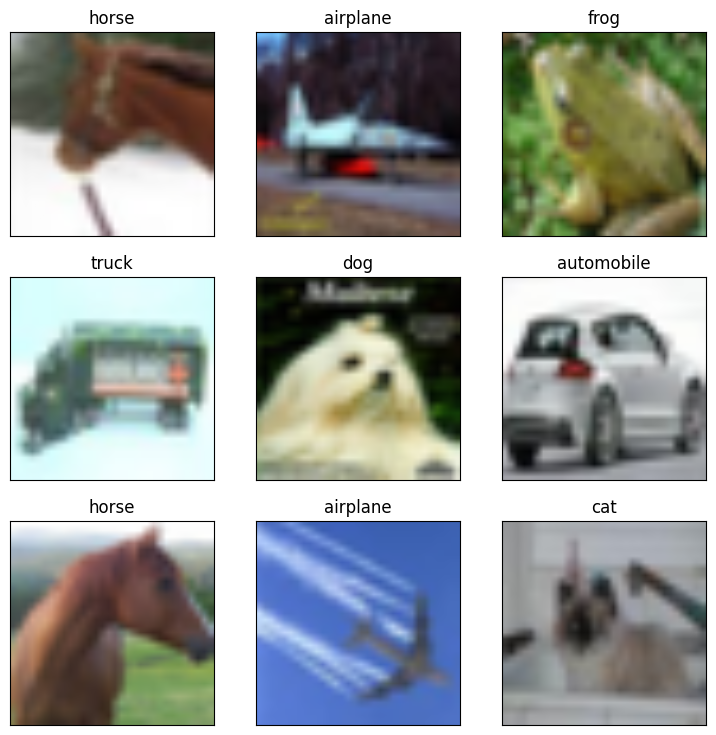

In [18]:
# Show some images with their labels.
images, labels = batch['image'][0][:9], batch['label'][0][:9]
titles = map(make_label_getter(dataset), labels.argmax(axis=1))
show_img_grid(images, titles)

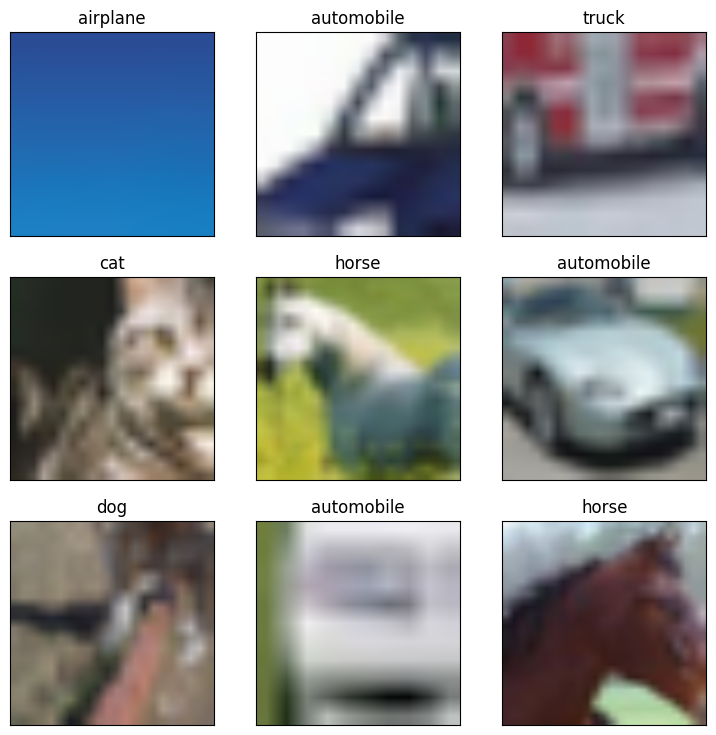

In [19]:
# Same as above, but with train images.
# Note how images are cropped/scaled differently.
# Check out input_pipeline.get_data() in the editor at your right to see how the
# images are preprocessed differently.
batch = next(iter(ds_train.as_numpy_iterator()))
images, labels = batch['image'][0][:9], batch['label'][0][:9]
titles = map(make_label_getter(dataset), labels.argmax(axis=1))
show_img_grid(images, titles)

### Load pre-trained

In [20]:
model_config = models_config.MODEL_CONFIGS[model_name]
model_config

classifier: token
hidden_size: 768
model_name: ViT-B_32
patches:
  size: !!python/tuple
  - 32
  - 32
representation_size: null
transformer:
  attention_dropout_rate: 0.0
  dropout_rate: 0.0
  mlp_dim: 3072
  num_heads: 12
  num_layers: 12

In [21]:
# Load model definition & initialize random parameters.
# This also compiles the model to XLA (takes some minutes the first time).
if model_name.startswith('Mixer'):
  model = models.MlpMixer(num_classes=num_classes, **model_config)
else:
  model = models.VisionTransformer(num_classes=num_classes, **model_config)
variables = jax.jit(lambda: model.init(
    jax.random.PRNGKey(0),
    # Discard the "num_local_devices" dimension of the batch for initialization.
    batch['image'][0, :1],
    train=False,
), backend='cpu')()

In [22]:
# Load and convert pretrained checkpoint.
# This involves loading the actual pre-trained model results, but then also also
# modifying the parameters a bit, e.g. changing the final layers, and resizing
# the positional embeddings.
# For details, refer to the code and to the methods of the paper.
params = checkpoint.load_pretrained(
    pretrained_path=f'{model_name}.npz',
    init_params=variables['params'],
    model_config=model_config,
)

INFO:absl:Inspect extra keys:
{'pre_logits/kernel', 'pre_logits/bias'}
INFO:absl:load_pretrained: drop-head variant


### Evaluate

In [23]:
# So far, all our data is in the host memory. Let's now replicate the arrays
# into the devices.
# This will make every array in the pytree params become a ShardedDeviceArray
# that has the same data replicated across all local devices.
# For TPU it replicates the params in every core.
# For a single GPU this simply moves the data onto the device.
# For CPU it simply creates a copy.
params_repl = flax.jax_utils.replicate(params)
print('params.cls:', type(params['head']['bias']).__name__,
      params['head']['bias'].shape)
print('params_repl.cls:', type(params_repl['head']['bias']).__name__,
      params_repl['head']['bias'].shape)

params.cls: ArrayImpl (10,)
params_repl.cls: ArrayImpl (8, 10)


In [24]:
# Then map the call to our model's forward pass onto all available devices.
vit_apply_repl = jax.pmap(lambda params, inputs: model.apply(
    dict(params=params), inputs, train=False))

In [25]:
def get_accuracy(params_repl):
  """Returns accuracy evaluated on the test set."""
  good = total = 0
  steps = input_pipeline.get_dataset_info(dataset, 'test')['num_examples'] // batch_size
  for _, batch in zip(tqdm.trange(steps), ds_test.as_numpy_iterator()):
    predicted = vit_apply_repl(params_repl, batch['image'])
    is_same = predicted.argmax(axis=-1) == batch['label'].argmax(axis=-1)
    good += is_same.sum()
    total += len(is_same.flatten())
  return good / total

In [26]:
# Random performance without fine-tuning.
get_accuracy(params_repl)

INFO:absl:Load dataset info from /root/tensorflow_datasets/cifar10/3.0.2
100%|██████████| 19/19 [00:08<00:00,  2.35it/s]


Array(0.10063734, dtype=float32)

### Fine-tune

In [27]:
# 100 Steps take approximately 15 minutes in the TPU runtime.
total_steps = 100
warmup_steps = 5
decay_type = 'cosine'
grad_norm_clip = 1
# This controls in how many forward passes the batch is split. 8 works well with
# a TPU runtime that has 8 devices. 64 should work on a GPU. You can of course
# also adjust the batch_size above, but that would require you to adjust the
# learning rate accordingly.
accum_steps = 8
base_lr = 0.03

In [28]:
# Check out train.make_update_fn in the editor on the right side for details.
lr_fn = utils.create_learning_rate_schedule(total_steps, base_lr, decay_type, warmup_steps)
# We use a momentum optimizer that uses half precision for state to save
# memory. It als implements the gradient clipping.
tx = optax.chain(
    optax.clip_by_global_norm(grad_norm_clip),
    optax.sgd(
        learning_rate=lr_fn,
        momentum=0.9,
        accumulator_dtype='bfloat16',
    ),
)
update_fn_repl = train.make_update_fn(
    apply_fn=model.apply, accum_steps=accum_steps, tx=tx)
opt_state = tx.init(params)
opt_state_repl = flax.jax_utils.replicate(opt_state)

In [29]:
# Initialize PRNGs for dropout.
update_rng_repl = flax.jax_utils.replicate(jax.random.PRNGKey(0))

100%|██████████| 100/100 [00:48<00:00,  2.08it/s]


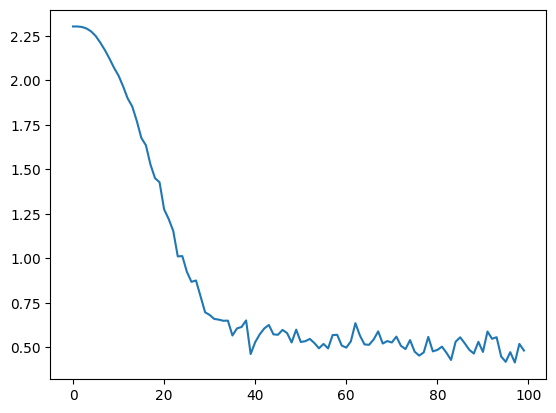

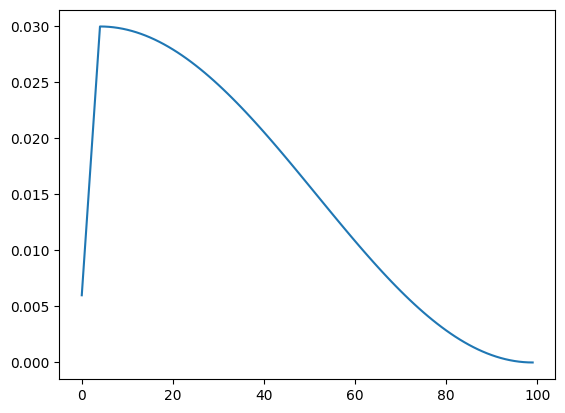

In [30]:
losses = []
lrs = []
# Completes in ~20 min on the TPU runtime.
for step, batch in zip(
    tqdm.trange(1, total_steps + 1),
    ds_train.as_numpy_iterator(),
):

  params_repl, opt_state_repl, loss_repl, update_rng_repl = update_fn_repl(
      params_repl, opt_state_repl, batch, update_rng_repl)
  losses.append(loss_repl[0])
  lrs.append(lr_fn(step))

plt.plot(losses)
plt.figure()
plt.plot(lrs)

In [31]:
# Should be ~96.7% for Mixer-B/16 or 97.7% for ViT-B/32 on CIFAR10 (both @224)
get_accuracy(params_repl)

INFO:absl:Load dataset info from /root/tensorflow_datasets/cifar10/3.0.2
100%|██████████| 19/19 [00:02<00:00,  6.34it/s]


Array(0.9774877, dtype=float32)

### Inference

In [32]:
# Download a pre-trained model.

if model_name.startswith('Mixer'):
  # Download model trained on imagenet2012
  ![ -e "$model_name"_imagenet2012.npz ] || gsutil cp gs://mixer_models/imagenet1k/"$model_name".npz "$model_name"_imagenet2012.npz
  model = models.MlpMixer(num_classes=1000, **model_config)
else:
  # Download model pre-trained on imagenet21k and fine-tuned on imagenet2012.
  ![ -e "$model_name"_imagenet2012.npz ] || gsutil cp gs://vit_models/imagenet21k+imagenet2012/"$model_name".npz "$model_name"_imagenet2012.npz
  model = models.VisionTransformer(num_classes=1000, **model_config)

import os
assert os.path.exists(f'{model_name}_imagenet2012.npz')

Copying gs://vit_models/imagenet21k+imagenet2012/ViT-B_32.npz...
==> NOTE: You are downloading one or more large file(s), which would
run significantly faster if you enabled sliced object downloads. This
feature is enabled by default but requires that compiled crcmod be
installed (see "gsutil help crcmod").

/ [1 files][336.9 MiB/336.9 MiB]   36.5 MiB/s                                   
Operation completed over 1 objects/336.9 MiB.                                    


In [33]:
# Load and convert pretrained checkpoint.
params = checkpoint.load(f'{model_name}_imagenet2012.npz')
params['pre_logits'] = {}  # Need to restore empty leaf for Flax.

In [34]:
# Get imagenet labels.
!wget https://storage.googleapis.com/bit_models/ilsvrc2012_wordnet_lemmas.txt
imagenet_labels = dict(enumerate(open('ilsvrc2012_wordnet_lemmas.txt')))

--2024-12-28 21:25:23--  https://storage.googleapis.com/bit_models/ilsvrc2012_wordnet_lemmas.txt
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.195.207, 173.194.206.207, 108.177.121.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.195.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 21675 (21K) [text/plain]
Saving to: ‘ilsvrc2012_wordnet_lemmas.txt.1’

ilsvrc2012_wordnet_ 100%[===================>]  21.17K  --.-KB/s    in 0.004s  

2024-12-28 21:25:24 (5.72 MB/s) - ‘ilsvrc2012_wordnet_lemmas.txt.1’ saved [21675/21675]



--2024-12-28 21:25:24--  https://picsum.photos/384
Resolving picsum.photos (picsum.photos)... 172.67.74.163, 104.26.5.30, 104.26.4.30, ...
Connecting to picsum.photos (picsum.photos)|172.67.74.163|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://fastly.picsum.photos/id/688/384/384.jpg?hmac=C_ChivQ6qicZxp-ofoLZmdB8plAHNYWeRrwNN4nBEMk [following]
--2024-12-28 21:25:25--  https://fastly.picsum.photos/id/688/384/384.jpg?hmac=C_ChivQ6qicZxp-ofoLZmdB8plAHNYWeRrwNN4nBEMk
Resolving fastly.picsum.photos (fastly.picsum.photos)... 151.101.1.91, 151.101.65.91, 151.101.129.91, ...
Connecting to fastly.picsum.photos (fastly.picsum.photos)|151.101.1.91|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 21403 (21K) [image/jpeg]
Saving to: ‘picsum.jpg’

picsum.jpg          100%[===================>]  20.90K  --.-KB/s    in 0.001s  

2024-12-28 21:25:26 (15.8 MB/s) - ‘picsum.jpg’ saved [21403/21403]



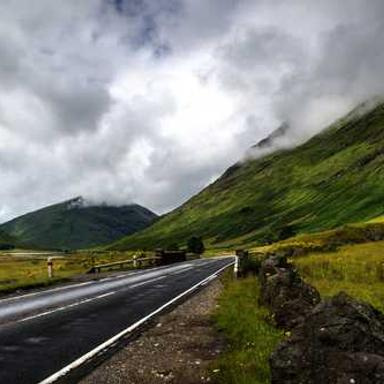

In [35]:
# Get a random picture with the correct dimensions.
resolution = 224 if model_name.startswith('Mixer') else 384
!wget https://picsum.photos/$resolution -O picsum.jpg
import PIL
img = PIL.Image.open('picsum.jpg')
img

In [36]:
# Predict on a batch with a single item (note very efficient TPU usage...)
logits, = model.apply(dict(params=params), (np.array(img) / 128 - 1)[None, ...], train=False)

In [37]:
preds = np.array(jax.nn.softmax(logits))
for idx in preds.argsort()[:-11:-1]:
  print(f'{preds[idx]:.5f} : {imagenet_labels[idx]}', end='')

0.50842 : valley, vale
0.16074 : alp
0.11770 : viaduct
0.02190 : lakeside, lakeshore
0.01797 : volcano
0.01150 : stone_wall
0.01146 : cliff, drop, drop-off
0.00811 : worm_fence, snake_fence, snake-rail_fence, Virginia_fence
0.00652 : promontory, headland, head, foreland
0.00633 : castle


In [39]:
import cv2
import os

def is_blurry(image_path, threshold=100):
    """
    Detecta si una imagen está borrosa usando el método Laplaciano.

    Parámetros:
        image_path (str): Ruta a la imagen.
        threshold (float): Umbral de varianza. Imágenes con varianza menor son consideradas borrosas.

    Retorna:
        bool: True si la imagen está borrosa, False si no lo está.
        float: Varianza del Laplaciano.
    """
    if not os.path.exists(image_path):
        raise FileNotFoundError(f"La imagen {image_path} no existe.")

    # Cargar la imagen en escala de grises
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if image is None:
        raise ValueError(f"No se pudo leer la imagen {image_path}.")

    # Aplicar el filtro Laplaciano y calcular su varianza
    laplacian_var = cv2.Laplacian(image, cv2.CV_64F).var()

    # Retornar si está borrosa según el umbral
    return laplacian_var < threshold, laplacian_var

def detect_blurry_images_in_directory(directory, threshold=100):
    """
    Detecta imágenes borrosas en un directorio.

    Parámetros:
        directory (str): Ruta al directorio de imágenes.
        threshold (float): Umbral de varianza para determinar si una imagen está borrosa.

    Retorna:
        List[Tuple[str, float, bool]]: Lista con la ruta, varianza y estado (borrosa o no) de cada imagen.
    """
    results = []
    for filename in os.listdir(directory):
        image_path = os.path.join(directory, filename)
        if os.path.isfile(image_path):
            try:
                is_blurred, variance = is_blurry(image_path, threshold)
                results.append((filename, variance, is_blurred))
            except Exception as e:
                print(f"Error procesando {filename}: {e}")
    return results


In [41]:
dataset_directory = "/content/drive/MyDrive/Colab_Notebooks\dataset\images\tiny-imagenet-200"  # Cambia esta ruta si es necesario

# Detectar imágenes borrosas
threshold = 100  # Ajusta el umbral según sea necesario
blurry_images = detect_blurry_images_in_directory(dataset_directory, threshold)

# Mostrar resultados
print("Resultados de la detección de imágenes borrosas:")
for filename, variance, is_blurred in blurry_images:
    status = "BORROSA" if is_blurred else "NÍTIDA"
    print(f"{filename}: Varianza = {variance:.2f}, Estado = {status}")

# Opcional: Filtrar imágenes borrosas y continuar con las nítidas
non_blurry_images = [f for f, v, b in blurry_images if not b]
print(f"Número de imágenes no borrosas: {len(non_blurry_images)}")


NotADirectoryError: [Errno 20] Not a directory: '/content/drive/MyDrive/Colab_Notebooks/ViT-B_32.npz'

In [48]:
import tensorflow_datasets as tfds
dataset, info = tfds.load("cifar10", with_info=True, as_supervised=True)
np.savez_compressed("cifar10_images.npz", images=[img.numpy() for img, _ in dataset['train']])


INFO:absl:Load dataset info from /root/tensorflow_datasets/cifar10/3.0.2
INFO:absl:Creating a tf.data.Dataset reading 1 files located in folders: /root/tensorflow_datasets/cifar10/3.0.2.
INFO:absl:Creating a tf.data.Dataset reading 1 files located in folders: /root/tensorflow_datasets/cifar10/3.0.2.
INFO:absl:Constructing tf.data.Dataset cifar10 for split None, from /root/tensorflow_datasets/cifar10/3.0.2


Claves disponibles en cifar10_images.npz: ['images']
Total de imágenes cargadas: 50000
Total de imágenes borrosas detectadas: 13


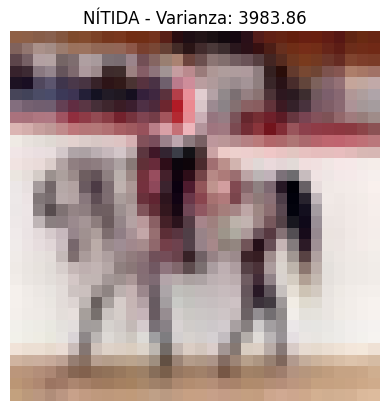

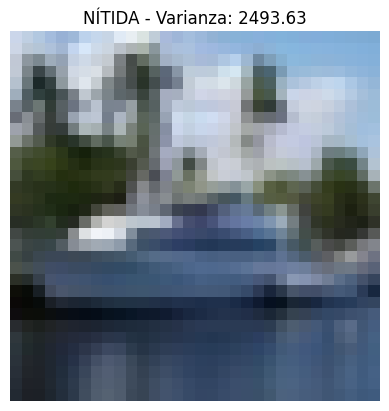

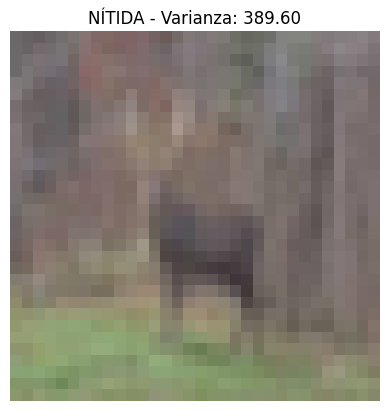

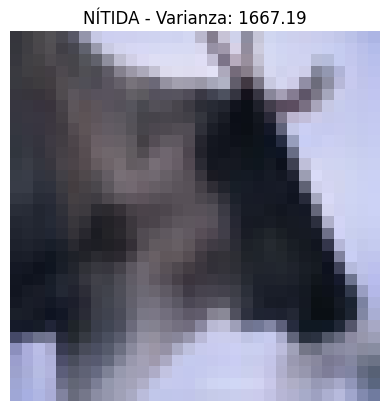

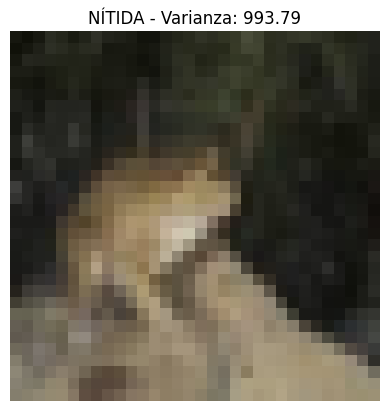


Resumen del análisis:
Total de imágenes: 50000
Imágenes borrosas: 13
Imágenes nítidas: 49987


In [52]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

# 1. Función para cargar un archivo .npz
def load_npz_file(file_path):
    """
    Carga un archivo .npz y devuelve su contenido.

    Args:
        file_path (str): Ruta al archivo .npz.

    Returns:
        dict: Diccionario con los datos almacenados en el archivo.
    """
    data = np.load(file_path, allow_pickle=True)
    print(f"Claves disponibles en {file_path}: {list(data.keys())}")
    return data

# 2. Función para detectar imágenes borrosas
def detect_blurry_images_from_npz(images, threshold=100):
    """
    Detecta imágenes borrosas en un array NumPy.

    Args:
        images (np.array): Array de imágenes.
        threshold (float): Umbral de varianza para determinar si está borrosa.

    Returns:
        List[Tuple[int, float, bool]]: Índice, varianza y estado (borrosa o no).
    """
    results = []
    for i, img in enumerate(images):
        # Convertir imagen a escala de grises si tiene 3 canales
        if len(img.shape) == 3 and img.shape[-1] == 3:
            gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        else:
            gray = img

        # Aplicar filtro Laplaciano
        laplacian_var = cv2.Laplacian(gray, cv2.CV_64F).var()
        is_blurred = laplacian_var < threshold
        results.append((i, laplacian_var, is_blurred))
    return results

# 3. Función para mostrar una imagen con Matplotlib
def show_image(image, title):
    """
    Muestra una imagen con Matplotlib.

    Args:
        image (np.array): Imagen en formato NumPy.
        title (str): Título para mostrar en la gráfica.
    """
    plt.imshow(image, cmap="gray" if len(image.shape) == 2 else None)
    plt.title(title)
    plt.axis("off")
    plt.show()

# 4. Aplicación principal: Analizar un archivo .npz
def analyze_blurry_images(npz_file_path, image_key, threshold=100):
    """
    Analiza las imágenes en un archivo .npz para detectar imágenes borrosas.

    Args:
        npz_file_path (str): Ruta al archivo .npz.
        image_key (str): Clave para acceder a las imágenes en el archivo.
        threshold (float): Umbral de varianza para detectar imágenes borrosas.

    Returns:
        None
    """
    # Cargar datos del archivo .npz
    data = load_npz_file(npz_file_path)

    # Obtener las imágenes
    if image_key not in data:
        print(f"Clave '{image_key}' no encontrada en el archivo.")
        return
    images = data[image_key]

    print(f"Total de imágenes cargadas: {len(images)}")

    # Detectar imágenes borrosas
    blurry_results = detect_blurry_images_from_npz(images, threshold)
    num_b_blurry = sum(1 for _, _, is_blurred in blurry_results if is_blurred)
    print(f"Total de imágenes borrosas detectadas: {num_b_blurry}")

    # Mostrar ejemplos de imágenes borrosas
    for idx, var, blurred in blurry_results[:5]:  # Primeras 5 imágenes
        status = "BORROSA" if blurred else "NÍTIDA"
        show_image(images[idx], f"{status} - Varianza: {var:.2f}")

    # Informe general
    total_images = len(images)
    print(f"\nResumen del análisis:")
    print(f"Total de imágenes: {total_images}")
    print(f"Imágenes borrosas: {num_b_blurry}")
    print(f"Imágenes nítidas: {total_images - num_b_blurry}")

# 5. Ejecutar el análisis
npz_file_path = "cifar10_images.npz"
image_key = "images"
threshold = 100  # Ajusta el umbral según sea necesario
analyze_blurry_images(npz_file_path, image_key, threshold)
#analyze_blurry_images(npz_file_path, image_key)


Total de imágenes analizadas: 10000
Total de imágenes borrosas detectadas: 6


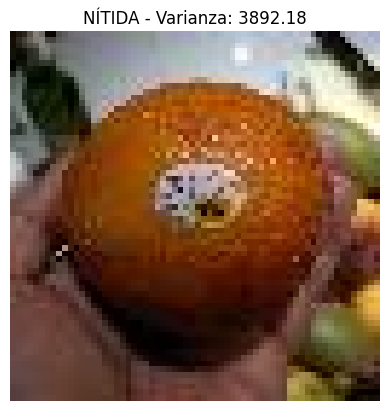

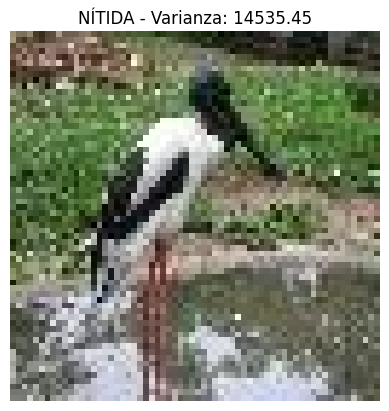

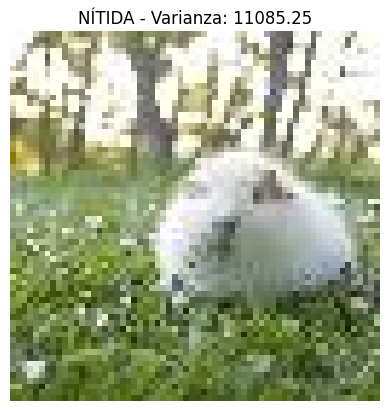

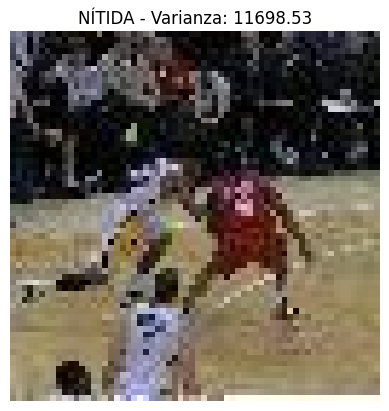

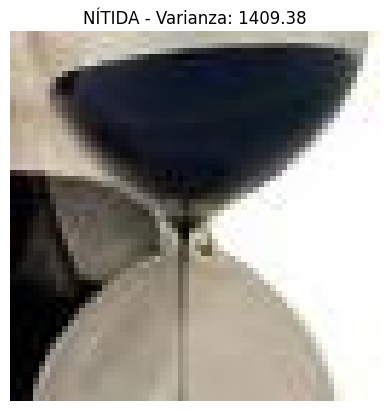


Resumen del análisis:
Imágenes totales: 10000
Imágenes borrosas: 6
Imágenes nítidas: 9994


In [54]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt

# 1. Función para detectar imágenes borrosas en un directorio
def detect_blurry_images_in_directory(directory_path, threshold=100):
    """
    Detecta imágenes borrosas en un directorio.

    Args:
        directory_path (str): Ruta al directorio de imágenes.
        threshold (float): Umbral de varianza para determinar si una imagen está borrosa.

    Returns:
        List[Tuple[str, float, bool]]: Nombre del archivo, varianza y estado (borrosa o no).
    """
    results = []
    for filename in os.listdir(directory_path):
        image_path = os.path.join(directory_path, filename)
        if os.path.isfile(image_path):  # Verificar si es un archivo
            # Cargar la imagen
            img = cv2.imread(image_path)
            if img is None:
                print(f"No se pudo leer la imagen: {filename}")
                continue

            # Convertir a escala de grises
            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

            # Aplicar filtro Laplaciano
            laplacian_var = cv2.Laplacian(gray, cv2.CV_64F).var()
            is_blurred = laplacian_var < threshold
            results.append((filename, laplacian_var, is_blurred))
    return results

# 2. Mostrar una imagen con Matplotlib
def show_image(image_path, title):
    """
    Muestra una imagen con Matplotlib.

    Args:
        image_path (str): Ruta de la imagen.
        title (str): Título para mostrar en la gráfica.
    """
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.title(title)
    plt.axis("off")
    plt.show()

# 3. Aplicación principal: Analizar un directorio de imágenes
def analyze_blurry_images_in_directory(directory_path, threshold=100):
    """
    Analiza las imágenes en un directorio para detectar imágenes borrosas.

    Args:
        directory_path (str): Ruta al directorio de imágenes.
        threshold (float): Umbral de varianza para detectar imágenes borrosas.

    Returns:
        None
    """
    # Detectar imágenes borrosas
    blurry_results = detect_blurry_images_in_directory(directory_path, threshold)
    num_b_blurry = sum(1 for _, _, is_blurred in blurry_results if is_blurred)
    print(f"Total de imágenes analizadas: {len(blurry_results)}")
    print(f"Total de imágenes borrosas detectadas: {num_b_blurry}")

    # Mostrar ejemplos de imágenes borrosas
    for filename, var, blurred in blurry_results[:5]:  # Primeras 5 imágenes
        status = "BORROSA" if blurred else "NÍTIDA"
        image_path = os.path.join(directory_path, filename)
        show_image(image_path, f"{status} - Varianza: {var:.2f}")

    # Informe general
    print(f"\nResumen del análisis:")
    print(f"Imágenes totales: {len(blurry_results)}")
    print(f"Imágenes borrosas: {num_b_blurry}")
    print(f"Imágenes nítidas: {len(blurry_results) - num_b_blurry}")

# 4. Ejecutar el análisis en un directorio
directory_path = "/content/drive/MyDrive/Colab_Notebooks/dataset/images/tiny-imagenet-200/tiny-imagenet-200/test/images"  # Ruta al directorio de imágenes
threshold = 100  # Ajusta el umbral según sea necesario
analyze_blurry_images_in_directory(directory_path, threshold)



Analizando con umbral = 10
Imágenes borrosas detectadas: 0

Analizando con umbral = 20
Imágenes borrosas detectadas: 0

Analizando con umbral = 30
Imágenes borrosas detectadas: 0

Analizando con umbral = 40
Imágenes borrosas detectadas: 2

Analizando con umbral = 50
Imágenes borrosas detectadas: 2

Analizando con umbral = 60
Imágenes borrosas detectadas: 4

Analizando con umbral = 70
Imágenes borrosas detectadas: 4

Analizando con umbral = 80
Imágenes borrosas detectadas: 4

Analizando con umbral = 90
Imágenes borrosas detectadas: 6

Analizando con umbral = 100
Imágenes borrosas detectadas: 6

Analizando con umbral = 110
Imágenes borrosas detectadas: 6

Analizando con umbral = 120
Imágenes borrosas detectadas: 6

Analizando con umbral = 130
Imágenes borrosas detectadas: 8

Analizando con umbral = 140
Imágenes borrosas detectadas: 9

Analizando con umbral = 150
Imágenes borrosas detectadas: 9

Analizando con umbral = 160
Imágenes borrosas detectadas: 9

Analizando con umbral = 170
Imág

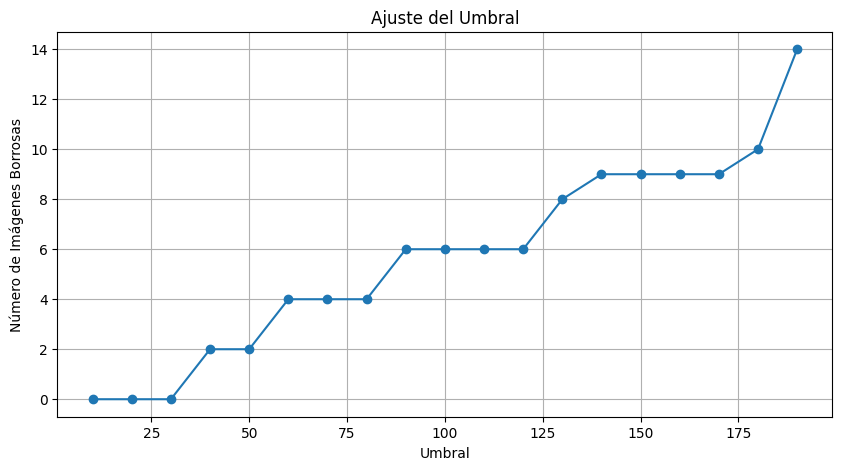

In [56]:
def analyze_thresholds(directory_path, thresholds):
    """
    Analiza un directorio de imágenes para múltiples umbrales.

    Args:
        directory_path (str): Ruta al directorio de imágenes.
        thresholds (List[int]): Lista de valores de umbral a probar.

    Returns:
        None
    """
    results_per_threshold = {}
    for threshold in thresholds:
        print(f"\nAnalizando con umbral = {threshold}")
        blurry_results = detect_blurry_images_in_directory(directory_path, threshold)
        num_b_blurry = sum(1 for _, _, is_blurred in blurry_results if is_blurred)
        results_per_threshold[threshold] = num_b_blurry
        print(f"Imágenes borrosas detectadas: {num_b_blurry}")

    # Graficar los resultados
    plt.figure(figsize=(10, 5))
    plt.plot(thresholds, [results_per_threshold[t] for t in thresholds], marker='o')
    plt.title("Ajuste del Umbral")
    plt.xlabel("Umbral")
    plt.ylabel("Número de Imágenes Borrosas")
    plt.grid(True)
    plt.show()

# Prueba de umbrales
directory_path = "/content/drive/MyDrive/Colab_Notebooks/dataset/images/tiny-imagenet-200/tiny-imagenet-200/test/images"
thresholds = list(range(10, 200, 10))  # Prueba valores de 10 a 200 con pasos de 10
analyze_thresholds(directory_path, thresholds)


In [ ]:
def validate_threshold(directory_path, threshold):
    """
    Muestra ejemplos de imágenes borrosas según un umbral.

    Args:
        directory_path (str): Ruta al directorio de imágenes.
        threshold (int): Umbral para detectar imágenes borrosas.

    Returns:
        None
    """
    blurry_results = detect_blurry_images_in_directory(directory_path, threshold)
    print(f"\nValidando con umbral = {threshold}")
    print(f"Imágenes borrosas detectadas: {sum(1 for _, _, is_blurred in blurry_results if is_blurred)}")

    # Mostrar hasta 5 imágenes borrosas
    for filename, var, blurred in blurry_results[:5]:
        if blurred:
            image_path = os.path.join(directory_path, filename)
            show_image(image_path, f"BORROSA - Umbral: {threshold}, Varianza: {var:.2f}")

# Probar varios umbrales manualmente
validate_threshold(directory_path, 50)   # Umbral bajo
validate_threshold(directory_path, 100)  # Umbral medio
validate_threshold(directory_path, 150)  # Umbral alto



Validando con umbral = 50
Imágenes borrosas detectadas: 2


In [ ]:
def generate_report(directory_path, thresholds):
    """
    Genera un informe detallado de análisis de borrosidad para múltiples umbrales.

    Args:
        directory_path (str): Ruta al directorio de imágenes.
        thresholds (List[int]): Lista de valores de umbral a probar.

    Returns:
        dict: Resultados por cada umbral.
    """
    report = {}
    for threshold in thresholds:
        blurry_results = detect_blurry_images_in_directory(directory_path, threshold)
        num_b_blurry = sum(1 for _, _, is_blurred in blurry_results if is_blurred)
        report[threshold] = {
            "total_images": len(blurry_results),
            "blurry_images": num_b_blurry,
            "non_blurry_images": len(blurry_results) - num_b_blurry
        }

    # Mostrar informe
    print("\nInforme por umbral:")
    for threshold, data in report.items():
        print(f"Umbral {threshold}: {data['blurry_images']} borrosas, {data['non_blurry_images']} nítidas, {data['total_images']} totales")

    return report

# Generar un informe detallado
thresholds = [50, 100, 150]
report = generate_report(directory_path, thresholds)
